In [1]:
import typing
import lzma
import os
from pathlib import Path
from types import MappingProxyType, SimpleNamespace

import cbor2
import attrs
import tqdm.auto
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import jaxtyping as jt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arc25.symmetry import SymOp, transform_vector
from arc25 import serialisation
from arc25.dsl.types import Vector, Dir4
from arc25.vision.symrep import SymRep, SymDecomp, SymDecompDims, standard_rep
from arc25.vision.linear import SymmetricLinear
from arc25.vision.rope import QKV, attention_RoPE_with_global
from arc25.vision.fields import Field, FieldDims
from arc25.vision.attention import FieldAttention
from arc25.vision.classification import ARCClassifier


In [2]:

os.environ["XLA_FLAGS"]="--xla_force_host_platform_device_count=2"

In [3]:
proj_root = Path("..").resolve()
data_root = proj_root / "data"

In [4]:
with lzma.LZMAFile(data_root/"repack/re-arc.cbor.xz","rb") as fh:
    src_data = serialisation.deserialise(cbor2.load(fh))

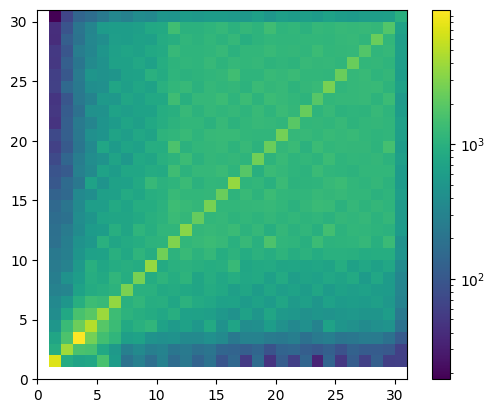

In [5]:

size_counts = np.zeros((31,31),int)
for k,v in src_data.items():
    for i,iop in enumerate(v):
        for kk in ["input","output"]:
            vv = getattr(iop,kk)
            if any(s>30 for s in vv.shape):
                continue 
            h,w = vv.shape
            size_counts[h,w] += 1

plt.pcolormesh(size_counts,norm="log")
plt.axis("square")
plt.colorbar()


In [6]:
import numba

def brute(size_counts,N=4):
    i = np.arange(0,31)
    ccounts = np.cumsum(np.cumsum(size_counts,axis=0),axis=1)
    ncells = i[:,None]*i
    total_cells = size_counts*ncells
    ccells = np.cumsum(np.cumsum(total_cells,axis=0),axis=1)
    mx = 30
    useful = ccells[mx,mx]
    best, bestb = brute_impl(ccounts,mx,N)
    return useful, best, bestb
    
@numba.njit
def brute_impl(ccounts,mx,N):
    best = 30**2*ccounts[-1,-1]
    bestb = np.zeros(N,dtype=np.int_)
    j = np.arange(N+1, dtype=np.int64)
    j[-1] = mx
    while True:
        cc = ccounts[j,:][:,j]
        bc = cc[1:]-cc[:-1]
        bcnt = bc[:,1:]-bc[:,:-1]
        bsz = j[1:,None]*j[1:]
        spent = np.sum(bcnt*bsz)
        if spent < best:
            best = spent
            bestb = j[1:].copy()

        i = N-1
        # find rightmost position that can be incremented
        while i > 0 and j[i]+1 == j[i+1]:
            i -= 1
        if i <= 0:
            # already at the last combination
            break
        j[i] += 1
        # reset the tail to the minimal ascending values
        while i+1<N:
            j[i+1] = j[i] + 1
            i += 1
        
    return best, bestb

for N in range(2,8):
    n_useful, n_spent, best = brute(size_counts, N=N)
    print(f"With {N=}, waste {(n_spent-n_useful)/1e6:.1f}/{n_spent/1e6:.1f} M (efficiency {100*n_useful/n_spent:.1f} %) with {best}")
            

With N=2, waste 199.2/422.9 M (efficiency 52.9 %) with [16 30]
With N=3, waste 121.2/344.9 M (efficiency 64.9 %) with [12 21 30]
With N=4, waste 86.3/310.0 M (efficiency 72.2 %) with [11 17 24 30]
With N=5, waste 64.7/288.4 M (efficiency 77.6 %) with [ 8 14 20 25 30]
With N=6, waste 50.7/274.4 M (efficiency 81.5 %) with [ 7 12 16 20 25 30]
With N=7, waste 41.5/265.3 M (efficiency 84.3 %) with [ 6 11 15 19 23 26 30]


In [7]:
dataset = []
#size_cuts = np.r_[11,17,24,30]
size_cuts = np.r_[16,30]
skipped = []
for k,v in tqdm.auto.tqdm(src_data.items()):
    for i,iop in enumerate(v):
        for kk in ["input","output"]:
            vv = getattr(iop,kk)
            if any(s>30 for s in vv.shape):
                skipped.append(vv)
                continue
            gs = tuple(int(size_cuts[np.searchsorted(size_cuts,s)]) for s in vv.shape)
            dataset.append(dict(
                image = vv._data,
                shape = vv.shape,
                size = int(np.prod(vv.shape)),
                grouping_shape = gs,
                challenge = k,
                type = kk,
            ))
print(f"Skipped {len(skipped)} out of {len(skipped)+len(dataset)} due to out-of-range shape")
datasrc = pd.DataFrame(dataset)
datasrc.head()

  0%|          | 0/400 [00:00<?, ?it/s]

Skipped 258 out of 800000 due to out-of-range shape


,image,shape,size,grouping_shape,challenge,type
0,"[[7, 7, 7, 7, 6, 7, 7, 7, 7], [7, 7, 7, 7, 7, ...","(6, 9)",54,"(16, 16)",a85d4709,input
1,"[[4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 3, 3, 3, 3, ...","(6, 9)",54,"(16, 16)",a85d4709,output
2,"[[6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6], [6, 6, ...","(15, 12)",180,"(16, 16)",a85d4709,input
3,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 3, ...","(15, 12)",180,"(16, 16)",a85d4709,output
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...","(2, 24)",48,"(16, 30)",a85d4709,input


In [8]:
total_waste = 0
total_cells = 0
min_grp = 1000000
for gs,grp in datasrc.groupby("grouping_shape"):
    s = gs[0]*gs[1]*grp.shape[0]
    n = grp["size"].sum()
    util = n/s
    waste = s-n
    total_waste += waste
    total_cells += n
    min_grp = min(min_grp, grp.shape[0])
    print(f"Group {str(gs):8s} has {grp.shape[0]:6} with an average utilisation of {util*100:.0f} %, wasting {waste*1e-3:.1f}k cells")
print(f"Total waste: {total_waste*1e-6:.1f}M cells vs {total_cells*1e-6:.1f}M useful cells")
print(f"Maximum batch size / minimum group size: {min_grp}")

Group (16, 16) has 252210 with an average utilisation of 31 %, wasting 44239.8k cells
Group (16, 30) has 160395 with an average utilisation of 52 %, wasting 37024.6k cells
Group (30, 16) has 159727 with an average utilisation of 52 %, wasting 36588.0k cells
Group (30, 30) has 227410 with an average utilisation of 60 %, wasting 81314.8k cells
Total waste: 199.2M cells vs 223.7M useful cells
Maximum batch size / minimum group size: 159727


In [9]:
import xarray as xa

challenge_index = pd.CategoricalIndex(sorted(datasrc.challenge.unique()))
itype_index = pd.CategoricalIndex(sorted(datasrc.type.unique()))
challenge_index, itype_index

(CategoricalIndex(['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', '045e512c',
                   '0520fde7', '05269061', '05f2a901', '06df4c85', '08ed6ac7',
                   ...
                   'f8b3ba0a', 'f8c80d96', 'f8ff0b80', 'f9012d9b', 'fafffa47',
                   'fcb5c309', 'fcc82909', 'feca6190', 'ff28f65a', 'ff805c23'],
                  categories=['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', ..., 'fcc82909', 'feca6190', 'ff28f65a', 'ff805c23'], ordered=False, dtype='category', length=400),
 CategoricalIndex(['input', 'output'], categories=['input', 'output'], ordered=False, dtype='category'))

In [10]:
padded_data = {}
for gs,grp in datasrc.groupby("grouping_shape"):
    n = grp.shape[0]
    images = np.zeros((n,)+gs,"i1")
    sizes = np.zeros((n,2),int)
    challenges = np.zeros((n,),int)
    itype = np.zeros((n,),int)
    for i,(_,row) in enumerate(grp.iterrows()):
        h,w = row["shape"]
        images[i,:h,:w] = row.image
        sizes[i,:] = h,w
        challenges[i] = challenge_index.get_loc(row.challenge)
        itype[i] = itype_index.get_loc(row.type)
    data = xa.Dataset(
        dict(
            images = (("idx","row","col"), images),
            sizes = (("idx","dim"), sizes),
            challenges = (("idx",),challenges),
            itype = (("idx",),itype),
        ),
        coords = dict(
            dim = pd.Index(["row","col"]),
        ),
    )
    padded_data[gs] = data
data

<xarray.Dataset> Size: 212MB
Dimensions:     (idx: 227410, row: 30, col: 30, dim: 2)
Coordinates:
  * dim         (dim) object 16B 'row' 'col'
Dimensions without coordinates: idx, row, col
Data variables:
    images      (idx, row, col) int8 205MB 6 6 6 6 6 6 6 6 6 ... 0 0 0 0 0 0 0 0
    sizes       (idx, dim) int64 4MB 25 24 25 24 18 21 18 ... 22 18 19 20 19 20
    challenges  (idx) int64 2MB 261 261 261 261 261 261 ... 233 233 233 233 233
    itype       (idx) int64 2MB 0 1 0 1 0 1 0 1 0 1 0 ... 1 0 1 0 1 0 1 0 1 0 1

In [11]:
def make_dataset(batch_size: int, rngs:nnx.Rngs):
    weights = {}
    for gs,data in padded_data.items():
        weights[gs] = data.idx.size
    logits = np.log(np.array(list(weights.values())))
    keys = tuple(weights.keys())
    rng = rngs
    seen = set()
    while True:
        gs = keys[rng.categorical(logits)]
        is_first_of_kind = gs not in seen
        seen.add(gs)
        data = padded_data[gs]
        assert data.idx.size >= batch_size
        i = set()
        while len(i) < batch_size:
            j = rng.randint((batch_size-len(i),),0,data.idx.size)
            i.update(int(v) for v in j)
        i = np.array(sorted(i))
        images = data.images.to_numpy()[i]
        sizes = data["sizes"].to_numpy()[i]
        labels = data.challenges.to_numpy()[i]
        yield dict(
            inputs = dict(image=images, size=sizes),
            label = labels,
        ), is_first_of_kind, 0

In [12]:
import dataclasses
from dataclasses import dataclass

In [13]:
@dataclass(frozen=True)
class ModelConfig:
    num_classes: int = 1000
    embed_dim: int = 256

@dataclass(frozen=True)
class TrainConfig:
    """Configuration for the training script."""
    seed: int = 42
    global_batch_size: int = 128  # across all devices
    ref_batch: int = 1024 # all learning rates refer to this batch size
    ref_epoch: int = 800000 # number of images that we call one epoch in reporting
    # Optimiser
    learning_rate: float = 3e-4
    betas: tuple[float, float] = (0.9, 0.999)
    eps: float = 1e-8
    weight_decay: float = 0.05
    grad_clip_norm: float = 1.0
    # Schedule    
    # in units of ref_batch images!
    num_train_steps: int = 1000
    warmup_steps: float = 10
    log_every_steps: int = 50

    # TODO: EMA


In [14]:

class TrainState(nnx.Module):
    """A frozen dataclass to hold the training state."""
    config: TrainConfig = dataclasses.field(metadata=dict(static=True))
    model: nnx.Module
    optimizer: nnx.Optimizer
    # ema_params: nnx.Params

    @classmethod
    def make(
        cls,
        model: nnx.Module,
        config: TrainConfig,
        *,
        rngs: nnx.Rngs,
    ) -> typing.Self:
        """Initializes the model, optimizer, and the combined training state."""

        step_scale = config.ref_batch / config.global_batch_size
        epoch_scale = config.ref_epoch / config.global_batch_size
        # Create the learning rate schedule (warmup + cosine decay is standard for ViTs)
        # with Linear LR scaling
        lr = config.learning_rate / step_scale
        zero_lr = lr * 0.001
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=zero_lr,
            peak_value=config.learning_rate,
            warmup_steps=int(round(config.warmup_steps*step_scale)),
            decay_steps=int(round((config.num_train_steps - config.warmup_steps)*step_scale)),
            end_value=zero_lr,
        )
    
        # Create the AdamW optimizer with gradient clipping
        tx = optax.chain(
            optax.clip_by_global_norm(config.grad_clip_norm),
            optax.adamw(
                learning_rate=lr_schedule,
                weight_decay=config.weight_decay,
                b1=config.betas[0],
                b2=config.betas[1], 
                eps=config.eps,
            ),
        )

        self = cls()
        self.config = config
        self.model = model
        self.optimizer = nnx.Optimizer(model, tx, wrt=nnx.Param)
        self.stats = {k:nnx.Variable(0) for k in ["steps","examples"]}

        return self

    def model_stats(self):
        stats = {}
        for k in ["model","optimizer"]:
            _, v = nnx.split(getattr(self, k))
            leaves = jax.tree_util.tree_leaves(v)
            total_params = sum((leaf.size for leaf in leaves), start=0)
            total_bytes = sum((leaf.nbytes for leaf in leaves), start=0)
            stats[k] = SimpleNamespace(params=total_params,bytes=total_bytes)
        
        return SimpleNamespace(**stats)

    @classmethod
    def loss_fn(cls, model, batch, **kw):
        inputs = batch["inputs"]
        logits = model(inputs["image"], inputs["size"], **kw)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch["label"],
            #label_smoothing=cfg.label_smoothing,
        ).mean()
        accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == batch["label"])
        return loss, dict(loss=loss, accuracy=accuracy)

    def batch_stats(self, batch_size:int|None=None,shape:tuple[int,int] = (30,30)):
        graph, state = nnx.split(self)
        def inference(state, batch):
            state = nnx.merge(graph, state)
            model = state.model
            model.eval()
            inputs = batch["inputs"]
            return model(inputs["image"], inputs["size"])
        def train(state, batch):
            state = nnx.merge(graph, state)
            model = state.model
            model.train()
            def loss_fn(model):
                return self.loss_fn(model, batch)
            grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
            (_, stats), grads = grad_fn(model)

            # Update optimizer state and compute new parameters
            state.optimizer.update(state.model, grads)
            _, state = nnx.split(state)
            return state, stats
            
        if batch_size is None:
            batch_size = self.config.global_batch_size
        batch = dict(
            inputs = dict(
                image = np.zeros((batch_size,)+shape,"i1"),
                size = np.tile(shape,(batch_size,1)),
            ),
            # TODO: num classes!
            label = np.arange(batch_size,dtype=int)%400,
        )
        stats = {}
        for k,fun in dict(
            inference=inference,
            train=train,
        ).items():
            # Analyze the forward pass function
            jfun = jax.jit(fun)
            tfun = jfun.trace(state, batch)
            cfun = tfun.lower()#.compile()
            cost = cfun.cost_analysis()
            stats[k] = SimpleNamespace(
                flops = cost.get("flops"),
                bytes_accessed = cost.get("bytes accessed"),
                bytes_out = cost.get("bytes accessedout"),
            )
            
        return SimpleNamespace(**stats)

    def train_step(self, batch, num_devices, **kw):
        @nnx.split_rngs(splits=num_devices)
        def wrapper(state, batch):
            return state._parallel_train_step(batch, tuple(sorted(kw.items())))

        batch = jax.tree.map(lambda x:x.reshape(num_devices,-1,*x.shape[1:]), batch)
        stats = wrapper(self, batch)

        # TODO: this one probably defeats latency hiding
        stats = jax.device_get(jax.tree.map(lambda x: x[0], stats))
        self.stats["steps"] += 1
        self.stats["examples"] += batch["label"].shape[0]
        stats.update({k:v.value for k,v in self.stats.items()})
        return stats

        
    @nnx.pmap(
        axis_name="data",
        in_axes=(nnx.StateAxes({('data',nnx.RngKey,nnx.RngCount): 0, ...: None}),0,None),
        static_broadcasted_argnums=2,
    )
    def _parallel_train_step(self, batch, kw):
        def loss_fn(model):
            return self.loss_fn(model, batch, **dict(kw))

        grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
        (_, stats), grads = grad_fn(self.model)

        grads = jax.lax.pmean(grads, axis_name='data')
        stats = jax.lax.pmean(stats, axis_name='data')
        
        self.optimizer.update(self.model, grads)
        return stats        


In [15]:
import time 

def main(model, config: TrainConfig, **kw):
    """The main entry point for the training script."""
    # Detect available devices (GPUs/TPUs)
    num_devices = jax.local_device_count()
    is_multi_device = num_devices > 1

    per_device_batch_size = config.global_batch_size // num_devices
    config = dataclasses.replace(config, global_batch_size=per_device_batch_size*num_devices)

    step_scale = config.ref_batch / config.global_batch_size
    epoch_scale = config.ref_epoch / config.global_batch_size
    
    print(f"--- ARC ViT Pre-training ---")
    print(f"Detected {num_devices} devices: {jax.devices()}")
    print(f"Mode: {'Single-device' if not is_multi_device else 'Multi-device (DDP)'}")
    print(f"Per-device batch size: {per_device_batch_size}")
    print(f"Global batch size: {config.global_batch_size}")
    print("----------------------------\n")

    # Setup PRNG key
    rngs = nnx.Rngs(config.seed)

    # 1. Setup Data Pipeline
    # ...

    # 2. Initialize Training State
    state = TrainState.make(
        model,
        config,
        rngs=rngs,
    )
    
    # 4. Start the training loop
    print("Starting training...")
    start_time = time.monotonic()
    prev_images = jit_imgs = 0
    prev_elapsed = jit_time = 0
    
    # Get an iterator for the dataset
    ds_iter = iter(make_dataset(config.global_batch_size, rngs=rngs))

    try:
        was_warmup = True
        stats = {}
        for step in (pbar := tqdm.auto.trange(int(round(config.num_train_steps*step_scale)))):
            # Fetch the next batch of data
            batch,is_first_of_kind,epoch = next(ds_iter)
            
            # Execute one parallel training step
            s = state.train_step(batch, num_devices, **kw)
    
            elapsed_time = time.monotonic() - start_time
            images = (step+1)*config.global_batch_size
            if is_first_of_kind:
                jit_time += elapsed_time - prev_elapsed
                jit_imgs += images - prev_images
            prev_elapsed = elapsed_time
            prev_images = images
            images_per_sec = (images-jit_imgs) / (elapsed_time-jit_time) if elapsed_time>jit_time+1 else images/elapsed_time
            info = dict(
                #step=step,
                epoch = epoch,
                refstep = images/config.ref_batch,
                refepoch= images/config.ref_epoch,
                images = images,
                images_per_sec=images_per_sec,
                seconds_per_epoch=config.ref_epoch/images_per_sec,
                **s
            )
            for k,v in info.items():
                stats.setdefault(k,[]).append(v)
            pbar.set_postfix(**{
                dict(images_per_sec="ips").get(k,k):f"{info[k]:.{v}f}"
                for k,v in dict(
                    loss=2,
                    accuracy=3,
                    images_per_sec=2,
                    refepoch=2,
                    epoch=0,
                    refstep=2,
                ).items()
            })
    except KeyboardInterrupt:
        pass

    print("\n--- Training Finished ---")
    stats = {k:np.array(v) for k,v in stats.items()}
    stats = pd.DataFrame(stats)
    return stats

In [ ]:
from arc25.lib.attrs import AttrsModule

class Latents(AttrsModule):
    mono: SymDecomp  # shape ... N R? Cm
    colour: SymDecomp  # shape ... M F R? Cf

    @property
    def projections(self):
        return dict(mono=self.mono,colour=self.colour)

    def map_projections(
        self, fun: typing.Callable[[SymDecomp], SymDecomp], *other: Self, **kw
    ) -> Self:
        return attrs.evolve(
            self,
            **{
                k: fun(v, *[getattr(o, k) for o in other], **kw)
                for k, v in self.projections.items()
            },
        )

    def map_representations(
        self, fun: typing.Callable[[jt.Float], jt.Float], *other: Self, **kw
    ) -> Self:
        return attrs.evolve(
            self,
            **{
                k: v.map_representations(fun, *[getattr(o, k) for o in other], **kw)
                for k, v in self.projections.items()
            },
        )

class PerceiverXAttnLayer(nnx.Module):
    def __init__(
        self,
        num_heads: int,
        hidden_size: FieldDims,
        latent_size: SymDecompDims,
        qkv_features: int,
        *,
        global_mix_reduction: int = 4,
        num_groups: int | None = None,
        dtype: Dtype | None = None,
        param_dtype: Dtype = jnp.float32,
        attention_dtype: Dtype | None = None,
        # broadcast_dropout: bool = True,
        dropout_rate: float = 0.0,
        deterministic: bool = False,
        precision: PrecisionLike = None,
        kernel_init: Initializer = default_kernel_init,
        # out_kernel_init: Initializer | None = None,
        bias_init: Initializer = default_bias_init,
        # out_bias_init: Initializer | None = None,
        use_bias: bool = True,
        hdrs_attend: bool = False,
        # attention_fn: Callable[..., Array] = dot_product_attention,
        normalize_qk: bool = False,
        keep_rngs: bool = True,
        rngs: rnglib.Rngs,        
    ):
        def make_linear(inf, outf, *, cls=SymmetricLinear):
            # TODO: do we have all relevant parameters?
            return cls(
                inf,
                outf,
                dtype=dtype,
                param_dtype=param_dtype,
                kernel_init=kernel_init,
                bias_init=bias_init,
                use_bias=use_bias,
                precision=precision,
                rngs=rngs,
            )
        self.n_features = n_features = qkv_features // num_heads
        nkv = 2 * num_groups * n_features
        nv = num_groups * n_features
        self.kv = hidden_size.map_projections(
            lambda k, v: make_linear(
                v,
                attrs.evolve(v, inv=nkv, equiv=nv),
            ),
            cls=dict,
        )
        nq = num_heads * n_features
        self.q = latent_size.map_projections(
            lambda k, v: make_linear(
                v,
                attrs.evolve(v, inv=nq, equiv=0),
            ),
            cls=dict,
        )

    def __call__(self, hidden: Field, latent: Latents) -> Latents:
        assert self.hidden_size.validate(
            hidden
        ), self.hidden_size.validation_problems(features)
        assert hidden.context.rep == hidden.cells.rep

        R = hidden.cells.rep.dim
        batch = hidden.cells.equiv.shape[:-5]
        B = int(np.prod(batch))
        Y, X, F = hidden.cells.equiv.shape[-5:-2]
        H = self.n_features
        D = H
        K = self.num_groups
        N = self.num_heads

        inputs = [
            r for p in hidden.projections.values() for r in p.representations.values()
        ] + [
            r for p in latent.projections.values() for r in p.representations.values()
        ]
        dtype = nnx.nn.dtypes.canonicalize_dtype(*inputs, dtype=self.dtype)
        attention_dtype = nnx.nn.dtypes.canonicalize_dtype(
            *inputs, dtype=self.attention_dtype
        )
        attention_dtype = jnp.promote_types(attention_dtype, jnp.float32)

        precision = self.precision

        # first; input projections
        qkv = {}
        for proj,src,tgt in [(self.q, latent, "Q"),(self.kv, hidden, "KV")]:
            for k, v in proj.items():
                inp = getattr(src, k)
                out = v(inp)
                rep = out.rep
                equiv = out.equiv
                inv = out.inv
    
                d = qkv.setdefault(k,{})
                for kk in tgt:
                    n = dict(Q=N * H, K=K * H, V=K * D)[kk]
                    if kk in "QK":
                        maybe_cast = lambda v: v.astype(attention_dtype)
                    else:
                        # jax.nn.dot_product_attention does not support mixed precision
                        maybe_cast = lambda v: v.astype(attention_dtype)
                    e = maybe_cast(equiv[..., :n])
                    # print(f"equiv {k}.{kk}.shape = {d[kk].shape}")
                    equiv = equiv[..., n:]
                    i = maybe_cast(inv[..., :n])
                    # print(f"inv {k}.{kk}.shape = {di[kk].shape}")
                    inv = inv[..., n:]
                    d[kk] = SymDecomp(inv=i,equiv=e,rep=rep)
                assert not inv.size, f"{k}: {inv.shape=}"
                assert not equiv.size
        qkv = SimpleNamespace(**{k:SimpleNamespace(**v) for k,v in qkv.items()})

        # second; X-attn to row/col headers (only mono)
        hdr_attn = []
        for axis in range(2):
            hdr = [qkv.cols, qkv.rows][axis]
            out = jax.nn.dot_product_attention(
                query=jnp.swapaxes(qkv.mono.Q.inv[:, :1, :, :, :], -3, -4).reshape(
                    B * F, 1, N, 2 * H
                ),
                key=jnp.swapaxes(efc.K, -3, -4).reshape(B * F, Y * X + 1, K, 2 * H),
                value=jnp.swapaxes(efc.V, -3, -4).reshape(B * F, Y * X + 1, K, D),
                mask=jnp.concatenate(
                    [
                        # TODO: should we self-attend here?
                        jnp.zeros((B * F, 1, 1, 1), bool),
                        jnp.tile(features.mask, (F, 1)).reshape(-1, 1, 1, Y * X),
                    ],
                    axis=-1,
                ),
            ).astype(dtype)
            hdr_attn.append(out)

In [16]:
dims = FieldDims.make(
    inv_fac = 2,
    context = 32,
    hdrs = 16,
    cells = 16,
)
arc_cls = ARCClassifier(
    hidden_size = dims,
    mha_features = 24*2,
    mlp_width_factor = 2,
    num_heads = 2,
    num_groups = 1,
    num_classes = 400,
    num_layers = 8,
    rngs = nnx.Rngs(0),
)

In [17]:
config = TrainConfig(
    global_batch_size = 16,
    num_train_steps = 1000,
    warmup_steps = 5,
    learning_rate = 3e-4,
    weight_decay = 0.05,
)

In [18]:
import humanize

if True:
    layer = arc_cls.encoder.blocks
    gs,state = nnx.split(layer)
    state = jax.tree.map(lambda v:v[0],state)
    layer = nnx.merge(gs,state)
    
    x = dims.make_empty(batch=(1,),shape=(30,30),flavours=11)
    def test_fun(model,x,**kw):
        return model(x,**kw)
    def unpack(obj,path=()):
        match obj:
            case SimpleNamespace():
                yield from unpack(vars(obj),path)
            case dict():
                for k,v in obj.items():
                    yield from unpack(v,path+(k,))
            case SymmetricLinear():
                yield path,obj.approximate_flops
            case nnx.Linear():
                yield path,obj.kernel.size
            case _:
                print(f"Ignoring {type(obj).__name__}")
    attn = layer.attn
    tot = 0
    for k,v in unpack(dict(mix=attn.cell_global_mix,qkv=attn.qkv,out=attn.out)):
        F = 11
        N = 30
        fac = dict(
            mix=F,
            context=F,
            rows=F*N,
            cols=F*N,
            cells=F*N*N,
        ).get(k[-1])
        tot += v*fac
        print(f"{'.'.join(k)}: {humanize.naturalsize(v*fac)}")
    print(f"Total attention projections: {humanize.naturalsize(tot)}")
    compiled = nnx.jit(test_fun).trace(layer.attn,x,deterministic=True).lower().compile()
    print(f"Total attn: {humanize.naturalsize(compiled.cost_analysis()["flops"])}")
    compiled = nnx.jit(test_fun).trace(layer.mlp,x,rngs=nnx.Rngs(0)).lower().compile()
    print(f"Total MLP: {humanize.naturalsize(compiled.cost_analysis()["flops"])}")
    compiled = nnx.jit(test_fun).trace(layer,x,rngs=nnx.Rngs(0)).lower().compile()
    print(f"Total Layer: {humanize.naturalsize(compiled.cost_analysis()["flops"])}")

mix: 5.6 kB
qkv.cells: 1.1 GB
qkv.cols: 9.1 MB
qkv.context: 2.3 MB
qkv.rows: 9.1 MB
out.cells: 524.6 MB
out.cols: 4.6 MB
out.context: 1.2 MB
out.rows: 4.6 MB
Total attention projections: 1.6 GB


/Users/yves/.pyenv/versions/3.13.7/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:124: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Total attn: 4.0 GB
Total MLP: 1.9 GB
Total Layer: 5.9 GB


In [19]:
import humanize

def print_stats(stats,path=()):
    for k,v in vars(stats).items():
        p = path+(k,)
        if isinstance(v, SimpleNamespace):
            print_stats(v, p)
            continue
        if v is None:
            continue
        if p[0] == "model":
            va = {"":v}
        else:
            va = dict(batch=v,example=v/config.global_batch_size)
        msg = []
        for kk,vv in va.items():
            if "bytes" in k:
                n = humanize.naturalsize(vv,binary=True)
            else:
                n = humanize.naturalsize(vv,gnu=True,format="%.1f ")
                if n.endswith("B"):
                    n = n[:-1]+" "
            if "flops" in k:
                n += "FLOPs"
            if kk:
                n += f" ({kk})"
            msg.append(n)
        n = "".join(f"{n:25s}" for n in msg)
        print(f"{'.'.join(p):32s}: {n}")


ts = TrainState.make(model=arc_cls, config=config, rngs=nnx.Rngs(0))
stats = SimpleNamespace(model=ts.model_stats(),batch=ts.batch_stats())
leaves = [
    a for p in dims.make_empty(
        batch=(config.global_batch_size,),
        shape=(30,30),
        flavours=11,
    ).projections.values() for a in p.representations.values()
]
stats.fields = SimpleNamespace(params=sum(a.size for a in leaves),bytes=sum(a.nbytes for a in leaves))
print_stats(stats)

/Users/yves/.pyenv/versions/3.13.7/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/flax/nnx/nn/dtypes.py:79: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  arrays = tuple(jnp.asarray(x, dtype) if x is not None else None for x in args)


model.model.params              : 1.8 M                    
model.model.bytes               : 7.3 MiB                  
model.optimizer.params          : 3.6 M                    
model.optimizer.bytes           : 14.6 MiB                 
batch.inference.flops           : 81.2 GFLOPs (batch)      5.1 GFLOPs (example)     
batch.inference.bytes_accessed  : 44.1 GiB (batch)         2.8 GiB (example)        
batch.train.flops               : 253.6 GFLOPs (batch)     15.8 GFLOPs (example)    
batch.train.bytes_accessed      : 328.0 GiB (batch)        20.5 GiB (example)       
fields.params                   : 25.2 M (batch)           1.6 M (example)          
fields.bytes                    : 201.5 MiB (batch)        12.6 MiB (example)       


In [20]:
stats = main(arc_cls, config, remat=True, unroll=False)

--- ARC ViT Pre-training ---
Detected 2 devices: [CpuDevice(id=0), CpuDevice(id=1)]
Mode: Multi-device (DDP)
Per-device batch size: 8
Global batch size: 16
----------------------------

Starting training...


  0%|          | 0/64000 [00:00<?, ?it/s]


--- Training Finished ---


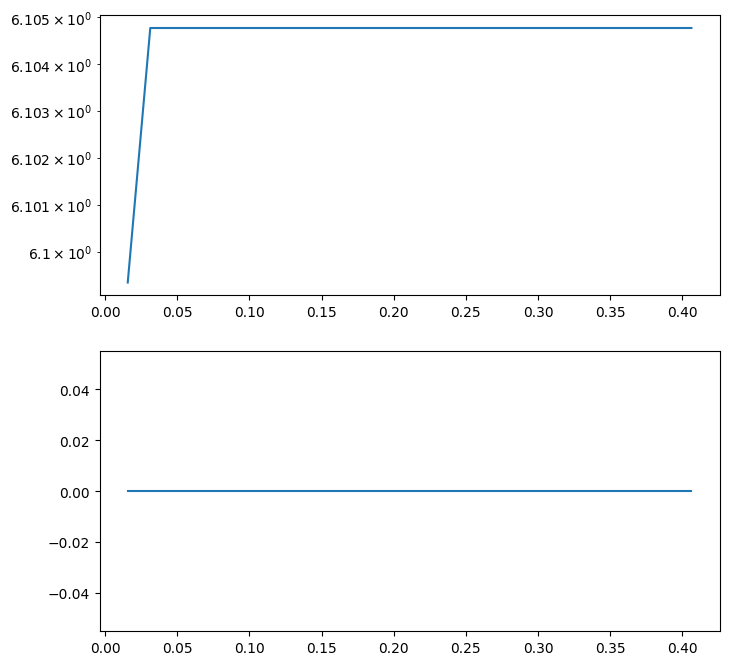

In [21]:
import matplotlib.pyplot as plt
from scipy import ndimage



def filt(signal, filter_width = 50):
    signal = ndimage.uniform_filter1d(signal, filter_width, mode="constant")
    signal /= ndimage.uniform_filter1d(np.ones_like(signal), filter_width, mode="constant")
    return signal

fig,axes = plt.subplots(2,1,figsize=(8,8))
ax = axes[0]
ax.semilogy(stats.refstep, filt(stats.loss))
ax = axes[1]
ax.plot(stats.refstep, filt(stats.accuracy))

In [22]:
import msgpack
import lzma
import anyio
import pickle

asdfasd

async with await anyio.open_file(data_root/"arc-vision-model.msgpack.xz","wb") as fh:
    compressor = lzma.LZMACompressor()
    
    async def write(*data):
        serialised = msgpack.dumps(tuple(data))
        compressed = await anyio.to_thread.run_sync(compressor.compress,serialised)
        await fh.write(compressed)
    
    graphdef,flatstate = nnx.graph.flatten(nnx.pure(nnx.state(arc_cls, nnx.Param)))
    await write("G",pickle.dumps(graphdef))
    pointer = ()
    for path,s in tqdm.auto.tqdm(flatstate):
        pstr = ".".join(str(v) for v in path)
        assert isinstance(s, jaxlib._jax.ArrayImpl)
        d = np.asarray(jax.device_get(s))
        neq = 0
        for i,(a,b) in enumerate(zip(pointer, path)):
            neq = i
            if a != b:
                break
        key = (neq,path[neq:])
        await write("A",neq,path[neq:],d.shape,str(d.dtype),bytes(d.data))
        pointer = path

NameError: name 'asdfasd' is not defined